In [ ]:
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv("province/export-jsps014-1h_cleaned.csv", parse_dates=["timestamp"], index_col="timestamp")

# ลบค่าที่ซ้ำกัน
df = df[~df.index.duplicated(keep="last")]

# เติม timestamp ที่ขาดให้ครบทุกวัน
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="H")
df = df.reindex(full_range)

# ใช้เฉพาะคอลัมน์ที่ต้องการ
df = df[['pm_2_5', 'humidity']]
df = df[(df['pm_2_5'] >= 0) & (df['pm_2_5'] <= 100)]

# เติมค่าที่ขาดด้วย Spline Interpolation
df['pm_2_5'] = df['pm_2_5'].interpolate(method='spline', order=2)
df['humidity'] = df['humidity'].interpolate(method='spline', order=2)

# เพิ่มฟีเจอร์ วัน เดือน ปี
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year

# ฟังก์ชันระบุฤดูกาลของไทย
def get_thai_season(month):
    if month in [3, 4, 5]:
        return 'summer'
    elif month in [6, 7, 8, 9, 10]:
        return 'rainy'
    else:
        return 'winter'

# เพิ่มคอลัมน์ฤดูกาล
df['season'] = df['month'].apply(get_thai_season)
# One-hot encoding ฤดูกาล
df = pd.get_dummies(df, columns=['season'], prefix='season')

# แปลงค่า True/False เป็น 1/0
df[['season_rainy', 'season_summer', 'season_winter']] = df[['season_rainy', 'season_summer', 'season_winter']].astype(int)

# เพิ่มฟีเจอร์ "วันหยุด" ของประเทศไทย
thai_holidays = holidays.TH(years=range(df.index.year.min(), df.index.year.max() + 1))
df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x in thai_holidays else 0)

# ตรวจสอบค่าว่างในแต่ละคอลัมน์
print("Missing values in df:")
print(df.isna().sum())  # ควรแสดง 0 ในทุกคอลัมน์

# แบ่งข้อมูลเป็น train set และ test set
train_size = len(df) - 15
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# เติมช่วงเวลาที่ขาดหายไปใน train_df
expected_train_index = pd.date_range(start=train_df.index.min(), end=train_df.index.max(), freq="H")
train_df = train_df.reindex(expected_train_index)

# เติมค่าที่ขาดในคอลัมน์ day, month, year
train_df['day'] = train_df.index.day
train_df['month'] = train_df.index.month
train_df['year'] = train_df.index.year

# เติมค่าที่ขาดในคอลัมน์ฤดูกาล
train_df['season'] = train_df['month'].apply(get_thai_season)
train_df = pd.get_dummies(train_df, columns=['season'], prefix='season')
train_df[['season_rainy', 'season_summer', 'season_winter']] = train_df[['season_rainy', 'season_summer', 'season_winter']].fillna(0).astype(int)

# เติมค่าที่ขาดด้วย interpolation
train_df['pm_2_5'] = train_df['pm_2_5'].interpolate(method='linear')
train_df['humidity'] = train_df['humidity'].interpolate(method='linear')
train_df['is_holiday'] = train_df['is_holiday'].fillna(0)  # เติมค่าว่างใน is_holiday ด้วย 0

# ตรวจสอบ train_df อีกครั้ง
print("Missing values in train_df after filling missing values:")
print(train_df.isna().sum())

# ฟีเจอร์ที่ใช้ในโมเดล (Exogenous Variables)
exog_features = ['humidity', 'is_holiday', 'season_rainy', 'season_summer', 'season_winter']
X_train = train_df[exog_features]  # ใช้เฉพาะ exogenous features
X_test = test_df[exog_features]    # ใช้เฉพาะ exogenous features

# ลบคอลัมน์ซ้ำใน X_train (ถ้ามี)
X_train = X_train.loc[:, ~X_train.columns.duplicated()]

# ตรวจสอบคอลัมน์ของ X_train และ X_test
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

# สร้างและฝึกโมเดล SARIMAX
model = SARIMAX(
    train_df['pm_2_5'],  # ข้อมูลอนุกรมเวลา (Target)
    exog=X_train,        # ตัวแปรภายนอก (Exogenous Variables)
    order=(1, 1, 1),     # Non-seasonal part (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # Seasonal part (P, D, Q, m) และ m=7 (weekly seasonality)
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

# ทำนายค่าในอนาคต
forecast = results.get_forecast(steps=len(test_df), exog=X_test)
forecast_values = forecast.predicted_mean

# คำนวณ MAE และ RMSE
mae = mean_absolute_error(test_df['pm_2_5'], forecast_values)
rmse = np.sqrt(mean_squared_error(test_df['pm_2_5'], forecast_values))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# พล็อตกราฟเปรียบเทียบค่าจริงกับค่าทำนาย
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df['pm_2_5'], label='Training Data')
plt.plot(test_df.index, test_df['pm_2_5'], label='Actual Test Data')
plt.plot(test_df.index, forecast_values, label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('pm_2_5')
plt.title('SARIMAX: Actual vs Forecasted pm_2_5')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Empty DataFrame
Columns: [pm_2_5, humidity, day, month, year]
Index: []


KeyError: "None of [Index(['season_rainy', 'season_summer', 'season_winter'], dtype='object')] are in the [columns]"

In [ ]:
# from statsmodels.tsa.arima.model import ARIMA

# # สร้างและฝึกโมเดล ARIMA
# model = ARIMA(train_df['pm_2_5'], order=(1, 1, 1))
# results = model.fit(disp=False)

# # ทำนายค่าในอนาคต
# forecast = results.get_forecast(steps=len(test_df))
# forecast_values = forecast.predicted_mean

TypeError: ARIMA.fit() got an unexpected keyword argument 'disp'

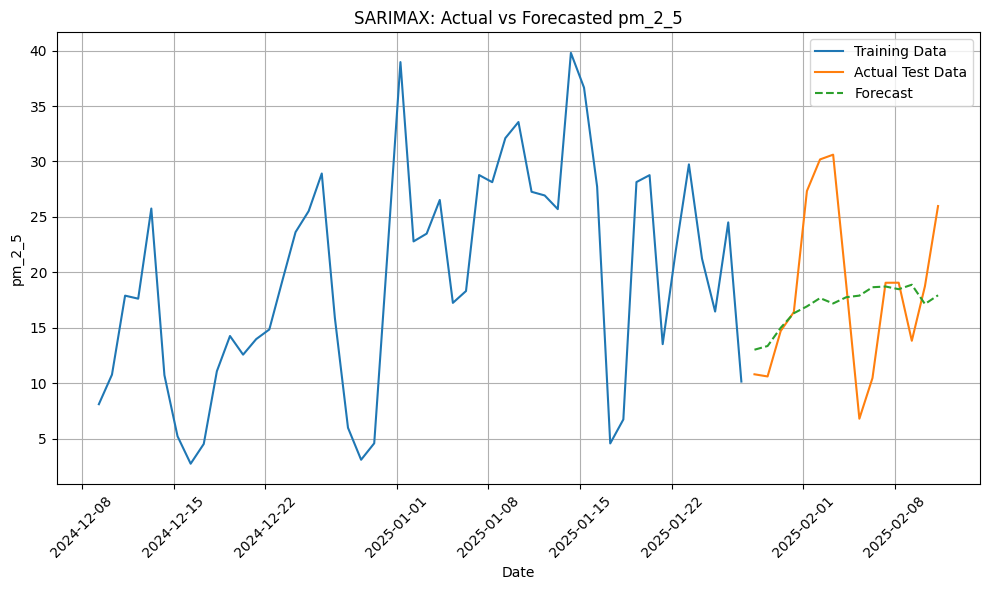

In [47]:
# พล็อตกราฟเปรียบเทียบค่าจริงกับค่าทำนาย
plt.figure(figsize=(10, 6))
plt.plot(train_df.index[-50:], train_df['pm_2_5'][-50:], label='Training Data')
plt.plot(test_df.index[-50:], test_df['pm_2_5'][-50:], label='Actual Test Data')
plt.plot(test_df.index[-50:], forecast_values[-50:], label='Forecast', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('pm_2_5')
plt.title('SARIMAX: Actual vs Forecasted pm_2_5')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()